# Random Act of Pizza
# Group: Tian Zhu, Yucheng Liu

In [106]:
# Data and Data Structures
import json
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
#from simpletransformers.classification import ClassificationModel, ClassificationArgs
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
from copy import deepcopy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from datetime import datetime

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [107]:
# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from wordcloud import WordCloud
import nltk

# Load data

In [108]:
# Load Train Data
dataset = pd.read_json("train.json")
# Load Test Data
sample_data = pd.read_json("test.json")
print("Dataset Shape:", dataset.shape)
print("Sample Shape:", sample_data.shape)
SEED = 0
train, test = train_test_split(dataset, test_size=0.2, random_state=SEED)

Dataset Shape: (4040, 32)
Sample Shape: (1631, 17)


# Original data without balancing for labels

In [109]:
# original data
# we can use this data for analysis purposes
train_data = train[train.columns.intersection(sample_data.columns)]
train_labels = train[['requester_received_pizza']]
train_all_labels = train[train.columns.difference(sample_data.columns)]
test_data = test[test.columns.intersection(sample_data.columns)]
test_labels = test[['requester_received_pizza']]
test_all_labels = test[test.columns.difference(sample_data.columns)]
print("Train data shape:",train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (3232, 17)
Test data shape: (808, 17)


# Data balanced for labels

In [110]:
# try balanced data instead
# this data can be used for 
train_positive = train[train['requester_received_pizza']==1]
train_negative = train[train['requester_received_pizza']==0]
true_weight_ratio = 1 + (train_negative['requester_received_pizza'].count() - train_positive['requester_received_pizza'].count())/(train_positive['requester_received_pizza'].count())
train_positive_balanced = train_positive.sample(frac=true_weight_ratio, replace=True, random_state=SEED)
train_balanced = pd.concat([train_positive_balanced, train_negative])

train_data = train_balanced[train_balanced.columns.intersection(sample_data.columns)]
train_labels = train_balanced[['requester_received_pizza']]
train_all_labels = train_balanced[train_balanced.columns.difference(sample_data.columns)]
test_data = test[test.columns.intersection(sample_data.columns)]
test_labels = test[['requester_received_pizza']]
test_all_labels = test[test.columns.difference(sample_data.columns)]
print("Train data shape:",train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4888, 17)
Test data shape: (808, 17)


# Data Exploration

In [111]:
# simple summary of the train data
train_data_summary = train_data.describe(include='all', datetime_is_numeric=True)
train_data_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
giver_username_if_known,4888,194,N/A,4188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_id,4888,3199,t3_pa5of,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_text_edit_aware,4888,3110,,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_title,4888,3188,[REQUEST]Need something to hold me over until ...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_request,4888.0,NaN,NaN,NaN,263.047387,304.572023,0.0,16.928573,168.355116,392.910712,2809.750787
requester_days_since_first_post_on_raop_at_request,4888.0,NaN,NaN,NaN,22.395692,86.260049,0.0,0.000000,0.000000,0.000000,785.457685
requester_number_of_comments_at_request,4888.0,NaN,NaN,NaN,120.655483,200.829541,0.0,0.000000,28.000000,149.000000,992.000000
requester_number_of_comments_in_raop_at_request,4888.0,NaN,NaN,NaN,0.940876,4.618623,0.0,0.000000,0.000000,0.000000,88.000000
requester_number_of_posts_at_request,4888.0,NaN,NaN,NaN,24.046031,58.009487,0.0,0.000000,5.000000,22.000000,867.000000
requester_number_of_posts_on_raop_at_request,4888.0,NaN,NaN,NaN,0.093494,0.423929,0.0,0.000000,0.000000,0.000000,5.000000


In [112]:
test_data_summary = test_data.describe(include='all', datetime_is_numeric=True)
test_data_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
giver_username_if_known,808,58,N/A,750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_id,808,808,t3_mqba5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_text_edit_aware,808,790,,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_title,808,807,[REQUEST],2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_request,808.0,NaN,NaN,NaN,263.001466,303.383540,0.0,4.243958,169.467633,418.139042,2521.263206
requester_days_since_first_post_on_raop_at_request,808.0,NaN,NaN,NaN,18.131502,75.590190,0.0,0.000000,0.000000,0.000000,711.307627
requester_number_of_comments_at_request,808.0,NaN,NaN,NaN,120.683168,196.713105,0.0,0.000000,27.000000,149.500000,994.000000
requester_number_of_comments_in_raop_at_request,808.0,NaN,NaN,NaN,0.636139,2.693566,0.0,0.000000,0.000000,0.000000,47.000000
requester_number_of_posts_at_request,808.0,NaN,NaN,NaN,21.433168,50.339029,0.0,0.000000,5.000000,23.000000,824.000000
requester_number_of_posts_on_raop_at_request,808.0,NaN,NaN,NaN,0.066832,0.311671,0.0,0.000000,0.000000,0.000000,3.000000


In [113]:
train_labels_summary = train_labels.describe(include='all', datetime_is_numeric=True)
train_labels_summary.transpose()

,count,unique,top,freq
requester_received_pizza,4888,2,False,2444


In [114]:
train_all_labels_summary = train_all_labels.describe(include='all', datetime_is_numeric=True)
train_all_labels_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
number_of_downvotes_of_request_at_retrieval,4888.0,NaN,NaN,NaN,2.404869,2.933467,0.000000,1.000000,2.000000,3.000000,47.000000
number_of_upvotes_of_request_at_retrieval,4888.0,NaN,NaN,NaN,6.448650,9.828706,0.000000,2.000000,4.000000,7.000000,345.000000
post_was_edited,4888.0,NaN,NaN,NaN,126340293.948650,394892045.555603,0.000000,0.000000,0.000000,0.000000,1380909467.000000
request_number_of_comments_at_retrieval,4888.0,NaN,NaN,NaN,3.545622,5.006152,0.000000,0.000000,2.000000,5.000000,61.000000
request_text,4888,3114,,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_retrieval,4888.0,NaN,NaN,NaN,779.426539,335.564441,45.291562,541.993782,777.877326,927.098241,2879.276319
requester_days_since_first_post_on_raop_at_retrieval,4888.0,NaN,NaN,NaN,538.170687,267.161725,0.000000,304.685324,554.541308,796.502564,927.447442
requester_number_of_comments_at_retrieval,4888.0,NaN,NaN,NaN,308.994681,364.142702,0.000000,11.000000,138.000000,527.250000,1000.000000
requester_number_of_comments_in_raop_at_retrieval,4888.0,NaN,NaN,NaN,3.555033,7.976474,0.000000,0.000000,1.000000,4.000000,139.000000
requester_number_of_posts_at_retrieval,4888.0,NaN,NaN,NaN,45.733020,92.956316,0.000000,3.000000,14.000000,48.000000,999.000000


In [115]:
# check correlation
train_data.corr()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
requester_account_age_in_days_at_request,1.000000,0.290781,0.469867,0.092597,0.403587,0.106010,0.594926,0.230525,0.096539,0.326364,0.326360
requester_days_since_first_post_on_raop_at_request,0.290781,1.000000,0.258185,0.378419,0.122034,0.375250,0.243950,0.144937,0.106137,0.207576,0.207578
requester_number_of_comments_at_request,0.469867,0.258185,1.000000,0.161788,0.333076,0.142166,0.715004,0.311078,0.110695,0.312597,0.312584
requester_number_of_comments_in_raop_at_request,0.092597,0.378419,0.161788,1.000000,0.022740,0.550553,0.088456,0.172836,0.168239,0.061607,0.061605
requester_number_of_posts_at_request,0.403587,0.122034,0.333076,0.022740,1.000000,0.116508,0.595644,0.448418,0.282481,0.096420,0.096419
requester_number_of_posts_on_raop_at_request,0.106010,0.375250,0.142166,0.550553,0.116508,1.000000,0.122176,0.196138,0.181725,0.128952,0.128950
requester_number_of_subreddits_at_request,0.594926,0.243950,0.715004,0.088456,0.595644,0.122176,1.000000,0.336767,0.140282,0.320726,0.320722
requester_upvotes_minus_downvotes_at_request,0.230525,0.144937,0.311078,0.172836,0.448418,0.196138,0.336767,1.000000,0.945008,0.156865,0.156862
requester_upvotes_plus_downvotes_at_request,0.096539,0.106137,0.110695,0.168239,0.282481,0.181725,0.140282,0.945008,1.000000,0.081171,0.081171
unix_timestamp_of_request,0.326364,0.207576,0.312597,0.061607,0.096420,0.128952,0.320726,0.156865,0.081171,1.000000,1.000000


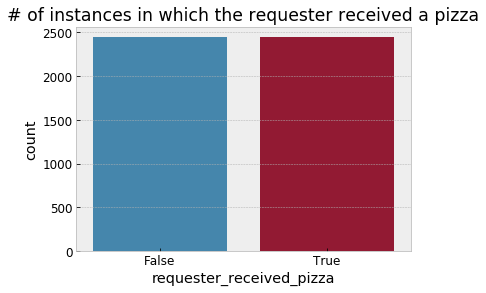

In [116]:
(sns.countplot(x = train_labels.requester_received_pizza).
set_title("# of instances in which the requester received a pizza"));

# Data Transformation

In [117]:
# extract the categorical/numerical fields to be separated from the free text analysis
columns_to_drop = ['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 'requester_subreddits_at_request', 'requester_username']
train_data_regression = train_data.drop(columns_to_drop, axis=1)
test_data_regression = test_data.drop(columns_to_drop, axis=1)

In [118]:
# convert time stamp to capture seasonality and time variant
train_data_regression['year_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).year)
train_data_regression['month_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).month)
train_data_regression['day_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).day)
train_data_regression['hour_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).hour)
train_data_regression['week_day_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).weekday())

test_data_regression['year_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).year)
test_data_regression['month_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).month)
test_data_regression['day_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).day)
test_data_regression['hour_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).hour)
test_data_regression['week_day_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).weekday())

# drop the timestamp
columns_to_drop = ['unix_timestamp_of_request_utc', 'unix_timestamp_of_request']
train_data_regression = train_data_regression.drop(columns_to_drop, axis=1)
test_data_regression = test_data_regression.drop(columns_to_drop, axis=1)

# Model based on numerical/categorical only

## KNN

In [20]:
model_knn = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17]}
clf = GridSearchCV(
    estimator=model_knn,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best k = ", clf.best_params_)

model_knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'])
model_knn.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_knn_prediction = model_knn.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_knn_prediction))

Best k =  {'n_neighbors': 3}
              precision    recall  f1-score   support

       False       0.75      0.62      0.68       602
        True       0.26      0.39      0.31       206

    accuracy                           0.56       808
   macro avg       0.51      0.51      0.50       808
weighted avg       0.62      0.56      0.59       808



## Regression

In [21]:
model_regression = LogisticRegression(solver="liblinear")
Cs = list(np.logspace(-4, 4, 20))
parameters = {'C':Cs}
clf = GridSearchCV(
    estimator=model_regression,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best C = ", clf.best_params_)

model_regression = LogisticRegression(C=clf.best_params_['C'], solver="liblinear")
model_regression.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_regression_prediction = model_regression.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_regression_prediction))

Best C =  {'C': 0.00026366508987303583}
              precision    recall  f1-score   support

       False       0.78      0.72      0.75       602
        True       0.33      0.39      0.36       206

    accuracy                           0.64       808
   macro avg       0.55      0.56      0.55       808
weighted avg       0.66      0.64      0.65       808



## Random Forest

In [22]:
# Random Forest
model_rf = RandomForestClassifier()
n_estimators = list(range(10,101,10))
max_features = list(range(6,len(train_data_regression.columns),2))
parameters = {'n_estimators':n_estimators, 'max_features':max_features}
clf = GridSearchCV(
    estimator=model_rf,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best Params = ", clf.best_params_)

model_rf = RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'], max_features=clf.best_params_['max_features'])
model_rf.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_rf_prediction = model_rf.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_rf_prediction))

Best Params =  {'max_features': 6, 'n_estimators': 50}
              precision    recall  f1-score   support

       False       0.76      0.92      0.83       602
        True       0.42      0.17      0.25       206

    accuracy                           0.73       808
   macro avg       0.59      0.55      0.54       808
weighted avg       0.68      0.73      0.68       808



# Machine Learning with XlNet

In [23]:
# an arbiturary set of hypter parameters.
def get_args():
    """Return a dictionary that can be passed into the model trainng function."""
    args = {
        "output_dir": "matching_model_class_weight_outputs/",
        "cache_dir": "matching_model_class_weight_cache_dir/",
        
        "fp16": True,
        "fp16_opt_level": "O1",
        "max_seq_length": 256,
        "train_batch_size": 16,
        "gradient_accumulation_steps": 1,
        "eval_batch_size": 16,
        "num_train_epochs": 1,
        "weight_decay": 0,
        "learning_rate": 8.0e-4, 
        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,

        "logging_steps": 50,
        "save_steps": 2000,

        "overwrite_output_dir": True,
        "reprocess_input_data": False,
        "evaluate_during_training": False,

        "process_count": 1,
        "n_gpu": 1
    }
    return args

In [24]:
training_args = get_args()

In [25]:
# prep the train/test data
df_train = pd.DataFrame()
df_train['text'] = train_data['request_title'] + " " + train_data['request_text_edit_aware']
df_train['labels'] = train_labels['requester_received_pizza'].astype(int)
df_test = pd.DataFrame()
df_test['text'] = test_data['request_title'] + " " + test_data['request_text_edit_aware']
df_test['labels'] = test_labels['requester_received_pizza'].astype(int)

In [26]:
# do sentence tokenization
df_train_sent = df_train.copy(deep=False)
df_train_sent['text'] = df_train['text'].apply(lambda x: sent_tokenize(x))
df_train_sent = df_train_sent.explode('text')
df_train_sent = df_train_sent.sample(frac=1, random_state=9999)

In [27]:
# check some examples
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    display(train_data['request_title'].head())

809                                                                                                                [Request AND offer!]
2636                                                                                                  [Request] Pizza for me and my boy
2003    [Request] Full-time student dad with 3 kids. Finals are next week, so I'm finishing projects today. Please help? (Portland, OR)
3854                          [Request] My dog of 18 years passed away last night, I really don't feel like cooking or doing much today
2023                                                                                  [Request] Pizza for my friend just out of surgery
Name: request_title, dtype: object

In [28]:
# use xlnet base cased model for transfer leraning
matching_model = ClassificationModel('xlnet', 'xlnet-base-cased', args=training_args, use_cuda=True)

NameError: name 'ClassificationModel' is not defined

In [ ]:
# for loading pretrained models only
matching_model = ClassificationModel('xlnet', model_name='matching_model_class_weight_outputs', args=training_args, use_cuda=True)

In [ ]:
# train on the shuffled sample
torch.cuda.empty_cache()
matching_model.train_model(df_train_sent.sample(frac=1, random_state=9999))

In [ ]:
# evaluate on dev set
result, model_outputs, wrong_predictions = matching_model.eval_model(df_test)

In [ ]:

result

In [ ]:
predictions, raw_outputs = matching_model.predict(df_test['text'].values)

In [ ]:
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=predictions))

# Data transformation for text data using pipeline

In [55]:
columns_to_drop = ['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 'requester_subreddits_at_request', 'requester_username']
train_data_regression = train_data.drop(columns_to_drop, axis=1)
test_data_regression = test_data.drop(columns_to_drop, axis=1)

In [156]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [170]:
#('requester_subreddits_at_request_idf',OneHotEncoder(dtype='int', handle_unknown='ignore'), 'requester_subreddits_at_request'),
text_columns = ['request_text_edit_aware', 'request_title']
train_data_text = train_data[text_columns]
pipeline_train  = pd.concat([train_data_regression, train_data_text], axis=1)
train_data_text = test_data[text_columns]
pipeline_test  = pd.concat([test_data_regression, train_data_text], axis=1)

In [179]:
MAX_FEAT_DESCP = 50000
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
preprocess = ColumnTransformer(
    [
     ('request_title_idf', CountVectorizer(), 'request_title'),
     ('request_text_edit_aware_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_text_edit_aware')],
    remainder='passthrough')

model = make_pipeline(
    preprocess,
    Ridge(solver = "lsqr", fit_intercept=False))
    
model.fit(pipeline_train, train_labels)

y_train_pred = model.predict(pipeline_train)
y_pred = model.predict(pipeline_test)

train_rmse = np.sqrt(mean_squared_error(y_train_pred, train_labels))
test_rmse = np.sqrt(mean_squared_error(y_pred, test_labels))
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train RMSE: 0.4988
Test RMSE: 0.5006


In [180]:
MAX_FEAT_DESCP = 50000
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
preprocess = ColumnTransformer(
    [('request_title_idf', CountVectorizer(), 'request_title'),
     ('request_text_edit_aware_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_text_edit_aware')],
    remainder='passthrough')

model = make_pipeline(
    preprocess,
    RandomForestClassifier())
    
model.fit(pipeline_train, train_labels)

y_train_pred = model.predict(pipeline_train)
y_pred = model.predict(pipeline_test)

print(classification_report(test_labels, y_pred))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


              precision    recall  f1-score   support

       False       0.75      1.00      0.85       602
        True       0.40      0.01      0.02       206

    accuracy                           0.74       808
   macro avg       0.57      0.50      0.44       808
weighted avg       0.66      0.74      0.64       808



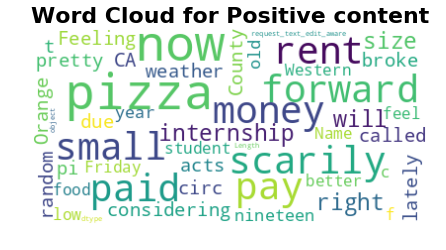

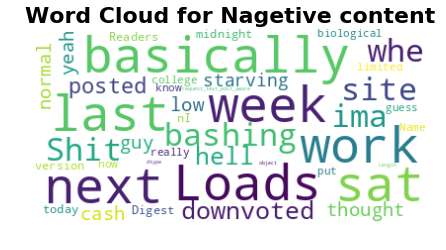

In [45]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive content",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive content",fontsize=22, fontweight='bold')
plt.show()

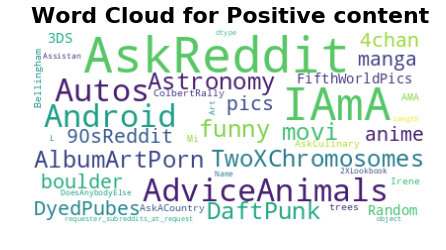

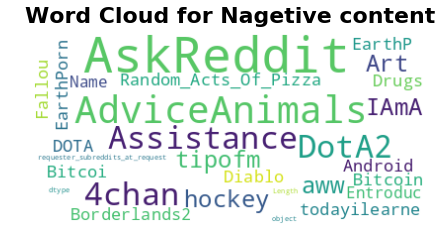

In [57]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['requester_subreddits_at_request']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive content",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['requester_subreddits_at_request']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive content",fontsize=22, fontweight='bold')
plt.show()

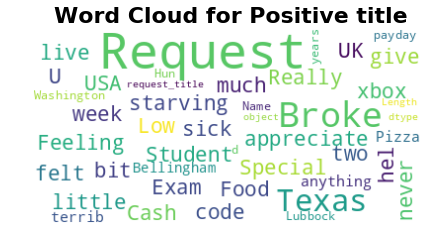

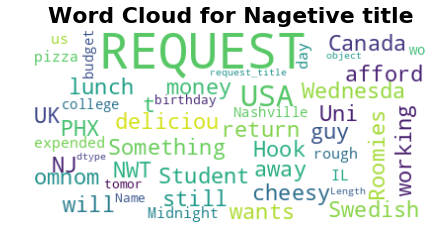

In [44]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['request_title']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive title",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['request_title']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive title",fontsize=22, fontweight='bold')
plt.show()

# TODO Create features from wordcloud

#  unused dev code

In [73]:
tfidf = TfidfVectorizer(preprocessor=textpreprocessor,stop_words=my_stop_words)
df_transform_text = tfidf.fit_transform(train_data['request_text_edit_aware'])
df_transform_title = tfidf.fit_transform(train_data['request_title'])
#df_transform_request = tfidf.fit_transform(train_data['requester_subreddits_at_request'])

In [66]:
import string
import re
from sklearn.feature_extraction import text
from scipy.sparse import csr_matrix, hstack

my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def textpreprocessor(s):
    s = s.lower()
    s = s = re.sub(r'\d{3,}', " numbers ", s)
    s = s.strip()
    temp = []
    for word in s.split():
        # average enligh word lenght is 5
        if len(word) < 6:
            temp.append(word)
        else:
            temp.append(word[:6])
    s = " ".join(temp)
    return s

In [154]:
test = train_data.copy()
processTextFeatures(test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterw', 'agains', 'alread', 'althou', 'amongs', 'amoung', 'anothe', 'anythi', 'anywhe', 'becaus', 'becomi', 'betwee', 'couldn', 'descri', 'elsewh', 'everyo', 'everyt', 'everyw', 'fiftee', 'furthe', 'hereaf', 'hereup', 'hersel', 'himsel', 'howeve', 'hundre', 'intere', 'meanwh', 'moreov', 'neithe', 'nevert', 'nothin', 'nowher', 'otherw', 'oursel', 'perhap', 'seemin', 'seriou', 'severa', 'sincer', 'someho', 'someon', 'someth', 'someti', 'somewh', 'themse', 'therea', 'thereb', 'theref', 'therei', 'thereu', 'throug', 'togeth', 'whatev', 'whenev', 'wherea', 'whereb', 'wherei', 'whereu', 'wherev', 'whethe', 'whithe', 'whoeve', 'withou', 'yourse'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


  giver_username_if_known request_id  \
0                     N/A   t3_l25d7   
2                     N/A   t3_lpu5j   
3                     N/A   t3_mxvj3   
5                     N/A  t3_14gmeb   
5                     N/A  t3_14gmeb   

                             request_text_edit_aware  \
0  Hi I am in need of food for my 4 children we a...   
2  My girlfriend decided it would be a good idea ...   
3  It's cold, I'n hungry, and to be completely ho...   
5  Feeling under the weather so I called out off ...   
5  Feeling under the weather so I called out off ...   

                                       request_title  \
0            Request Colorado Springs Help Us Please   
2  [Request] Hungry couple in Dundee, Scotland wo...   
3  [Request] In Canada (Ontario), just got home f...   
5  [REQUEST] I'll give a two week xbox live code ...   
5  [REQUEST] I'll give a two week xbox live code ...   

   requester_account_age_in_days_at_request  \
0                                  0.0

TypeError: cannot concatenate object of type '<class 'scipy.sparse.csr.csr_matrix'>'; only Series and DataFrame objs are valid

In [152]:
from sklearn.preprocessing import MultiLabelBinarizer
def processTextFeatures(df):
    columns_to_drop = ['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 'requester_subreddits_at_request', 'requester_username']
    # transform username to binary 
    df['giver_username_if_known']
    df["username_boolean"] = [1 if i != "N/A" else 0 for i in train_data['giver_username_if_known'].values]
    # Create Sparse matrix of words
    tfidf = TfidfVectorizer(preprocessor=textpreprocessor,stop_words=my_stop_words)
    df_transform_text = tfidf.fit_transform(df['request_text_edit_aware'])
    df_transform_title = tfidf.fit_transform(df['request_title'])
    
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('requester_subreddits_at_request')),
                          columns=mlb.classes_,
                          index=df.index))
    print(df.head())
    
    combined_df= pd.concat([df,df_transform_title, df_transform_text], axis=1)
    

    
    
    combined_df = combined_df.drop(columns_to_drop, axis=1)
    return df

    
    

In [153]:
len(train_data_regression)

4888

In [140]:
train_data[text_columns].reset_index()

,index,request_text_edit_aware,request_title,requester_subreddits_at_request
0,809,"Hey guys! I've been craving pizza lately, and ...",[Request AND offer!],"[RandomActsOfGaming, Random_Acts_Of_Pizza, aww..."
1,2636,"I don't normally ask for things from people, e...",[Request] Pizza for me and my boy,"[AskReddit, videos]"
2,2003,My wife and I are both full time students. She...,[Request] Full-time student dad with 3 kids. F...,"[4chan, AdviceAnimals, AlienBlue, AnythingGoes..."
3,3854,"My dachshund, stretch, passed away last night....",[Request] My dog of 18 years passed away last ...,"[3amjokes, AdviceAnimals, AskReddit, Campingan..."
4,2023,My friend has a foot condition that he was bor...,[Request] Pizza for my friend just out of surgery,"[AdviceAnimals, AskReddit, LadyBoners, Random_..."
...,...,...,...,...
4883,763,Just a normal guy here that is low on cash (no...,[Request] Swedish guy that wants to omnom some...,"[4chan, AskReddit, DOTA, Diablo, DotA2, EarthP..."
4884,835,So yeah. I'm starving and it's midnight.\nI do...,[Request] Midnight pizza?,[]
4885,3264,Readers Digest version of today: My biological...,"[request] IL, USA // Had a rough day, could us...",[]
4886,2607,So I'm in college now and am on a very limited...,(REQUEST) On an expended college budget and wo...,[]


In [134]:
train_data_regression.reset_index()

,index,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,year_of_request,month_of_request,day_of_request,hour_of_request,week_day_of_request
0,809,71.433935,68.894873,20,8,4,2,6,65,87,2012,2,2,1,3
1,2636,174.948565,0.000000,1,0,1,0,2,2,6,2011,7,25,15,0
2,2003,705.713403,0.000000,393,0,239,0,76,32025,139199,2012,6,9,18,5
3,3854,1207.884826,605.814525,892,6,32,1,57,5171,8031,2013,7,19,20,4
4,2023,68.818877,6.558414,223,1,0,0,18,874,1232,2012,5,12,17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,763,469.779097,0.000000,131,0,7,0,29,814,1620,2011,9,14,16,2
4884,835,0.000000,0.000000,0,0,0,0,0,0,0,2011,8,16,5,1
4885,3264,0.000000,0.000000,0,0,0,0,0,0,0,2012,6,28,23,3
4886,2607,0.000000,0.000000,0,0,0,0,0,0,0,2012,3,21,4,2


In [165]:
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
train_data_text = train_data[text_columns]
pipeline_train  = pd.concat([train_data_regression, train_data_text], axis=1)

In [150]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create Function Transformer to use Feature Union
columns_to_drop = ['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 'requester_subreddits_at_request', 'requester_username']
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
def get_numeric_data(x):
    print(x)
    for record in x:
        print(record[:-4])
        result = record[:-4].astype(float)
    return [record[:-4].astype(float) for record in x]

def get_text_data(x):
    return [record[-3] for record in x]

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

# Grid Search Parameters for RandomForest
param_grid = {'clf__n_estimators': np.linspace(1, 100, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

# Training config
kfold = StratifiedKFold(n_splits=7)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Perform GridSearch
rf_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(pipeline_train, train_labels)
rf_best = rf_model.best_estimator_

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


      requester_account_age_in_days_at_request  \
809                                  71.433935   
2636                                174.948565   
2003                                705.713403   
3854                               1207.884826   
2023                                 68.818877   
...                                        ...   
763                                 469.779097   
835                                   0.000000   
3264                                  0.000000   
2607                                  0.000000   
2732                                400.661134   

      requester_days_since_first_post_on_raop_at_request  \
809                                           68.894873    
2636                                           0.000000    
2003                                           0.000000    
3854                                         605.814525    
2023                                           6.558414    
...                                    

[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished


AttributeError: 'str' object has no attribute 'astype'